## Project Overview

This notebook focuses on the data cleaning and preparation phase of an end-to-end
e-commerce analytics project. The goal is to ensure data quality, consistency,
and analytical readiness while preserving the original business signals embedded
in the data.

All cleaning decisions are made with downstream analysis and business interpretability
in mind, rather than aggressive data removal.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

# Import Libraries & Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# getting data

In [3]:
orders = pd.read_csv(r"../Data/raw_data/olist_orders_dataset.csv")
order_reviews = pd.read_csv(r"../Data/raw_data/olist_order_reviews_dataset.csv")
order_payments = pd.read_csv(r"../Data/raw_data/olist_order_payments_dataset.csv")
order_items = pd.read_csv(r"../Data/raw_data/olist_order_items_dataset.csv")
products = pd.read_csv(r"../Data/raw_data/olist_products_dataset.csv")
category = pd.read_csv(r"../Data/raw_data/product_category_name_translation.csv")
sellers = pd.read_csv(r"../Data/raw_data/olist_sellers_dataset.csv")
customers = pd.read_csv(r"../Data/raw_data/olist_customers_dataset.csv")

In [4]:
def iqr_outlier_flag_by_group(df, value_col, group_col, k=1.5, two_sided=True):
    """
    Return a boolean Series (same length as df) marking outliers in `value_col`
    using IQR computed within each `group_col`.

    two_sided=True  -> outliers if value < Q1-k*IQR OR value > Q3+k*IQR
    two_sided=False -> outliers if value > Q3+k*IQR only (useful for weights/sizes)
    """
    g = df.groupby(group_col)[value_col]

    q1 = g.transform(lambda s: s.quantile(0.25))
    q3 = g.transform(lambda s: s.quantile(0.75))
    iqr = q3 - q1

    lower = q1 - k * iqr
    upper = q3 + k * iqr
    
    if two_sided:
        return (df[value_col] < lower) | (df[value_col] > upper)
    else:
        return df[value_col] > upper


def flag_rate(flag_series):
    """Return % rate for a boolean Series."""
    return round(flag_series.mean() * 100, 2)


## Data Preparation

In this phase, raw datasets are loaded and prepared for analysis. The focus is on:

- Ensuring correct data types
- Identifying missing values and duplicates
- Validating logical and temporal consistency
- Preserving meaningful variations in the data




**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Orders Dataset

The orders dataset represents the core transactional layer of the marketplace.
It captures the lifecycle of each order from purchase to delivery.

Key cleaning objectives for this dataset include:
- Validating order lifecycle timestamps
- Handling missing delivery-related dates
- Identifying logically inconsistent order timelines
- Creating analytical flags instead of altering raw behavior


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
orders.isna().any()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool

In [8]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [9]:
# Map detailed order statuses into high-level order stages for analysis
orders['order_stage'] = np.where(
    orders['order_status'] == 'delivered',
    'completed',
    'not_completed'
)

In [10]:
# Fill missing timestamps only for completed orders using logical timeline references
completed = orders['order_stage'] == 'completed'

orders.loc[completed, 'order_approved_at'] = (
    orders.loc[completed, 'order_approved_at']
    .fillna(orders.loc[completed, 'order_purchase_timestamp'])
)

orders.loc[completed, 'order_delivered_carrier_date'] = (
    orders.loc[completed, 'order_delivered_carrier_date']
    .fillna(orders.loc[completed, 'order_approved_at'])
)

orders.loc[completed, 'order_delivered_customer_date'] = (
    orders.loc[completed, 'order_delivered_customer_date']
    .fillna(orders.loc[completed, 'order_estimated_delivery_date'])
)


In [11]:
orders[orders['order_stage'] == "completed"].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_stage                      0
dtype: int64

In [12]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1781
order_delivered_customer_date    2957
order_estimated_delivery_date       0
order_stage                         0
dtype: int64

In [13]:
orders.loc[orders['order_stage']=='completed', 
           ['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']].isna().sum()


order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
dtype: int64

#

### Missing Values Assessment

Missing values in order-related timestamps are examined carefully to distinguish
between incomplete records and valid business scenarios, such as canceled or
non-delivered orders.

#

**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [14]:
orders.duplicated().sum()

np.int64(0)

In [15]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
order_stage                      object
dtype: object

In [16]:
# Convert order lifecycle timestamp columns to datetime format

dt_cols = [
    "order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"
]

orders[dt_cols] = orders[dt_cols].apply(lambda s: pd.to_datetime(s, errors="coerce"))


In [17]:
orders[dt_cols].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [18]:
# Check for timeline inconsistencies in the order lifecycle

bad = orders[
    (orders['order_purchase_timestamp'] > orders['order_approved_at']) |
    (orders['order_approved_at'] > orders['order_delivered_carrier_date']) |
    (orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date'])
]

bad.shape[0]


1382

In [19]:
orders[orders['order_purchase_timestamp'] > orders['order_approved_at']] #aproved

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_stage


In [20]:
orders[orders['order_approved_at'] > orders['order_delivered_carrier_date']].head() #problem 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_stage
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,completed
64,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,delivered,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15,completed
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31,completed
210,412fccb2b44a99b36714bca3fef8ad7b,c6865c523687cb3f235aa599afef1710,delivered,2018-07-22 22:30:05,2018-07-23 12:31:53,2018-07-23 12:24:00,2018-07-24 19:26:42,2018-07-31,completed
415,56a4ac10a4a8f2ba7693523bb439eede,78438ba6ace7d2cb023dbbc81b083562,delivered,2018-07-22 13:04:47,2018-07-27 23:31:09,2018-07-24 14:03:00,2018-07-28 00:05:39,2018-08-06,completed


In [21]:
orders[orders['order_approved_at'] > orders['order_delivered_carrier_date']].shape

(1359, 9)

In [22]:
orders[orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date']].head() # problem 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_stage
6437,a1abeb653a4d4cd1e142ccb8c82cd069,5f50465da00b7fed5dd1239f4ecf6e2c,delivered,2017-07-20 11:20:52,2017-07-21 06:43:14,2017-07-28 16:57:58,2017-07-25 19:32:56,2017-08-14,completed
9553,383aa8b2724fe452d9ccd9934a8c628b,b1cb2f9d7a19480f3749e248db14d58f,delivered,2017-07-02 20:58:43,2017-07-02 21:10:20,2017-07-07 17:22:41,2017-07-06 14:27:51,2017-07-21,completed
13487,cb1134f9010d242e9515ad1c78ec0c39,2fd33ac77677bd214b1882868317eeed,delivered,2017-07-16 12:35:34,2017-07-18 06:03:50,2017-07-20 19:22:02,2017-07-19 14:13:28,2017-08-08,completed
14474,dceb62e8fa94b46006c9554fed743df0,2721900eb4e0f1cc2c836dd7bc1b1e11,delivered,2017-07-20 20:58:05,2017-07-22 11:45:11,2017-08-01 18:23:30,2017-07-26 18:09:10,2017-08-11,completed
19268,5f9d46795c3126674e52becb3a1a517f,79287bcaafdde5c793b996fc40bb7d9f,delivered,2017-07-18 11:48:20,2017-07-18 12:03:29,2017-07-20 23:03:42,2017-07-20 18:52:41,2017-07-31,completed


In [23]:
orders[orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date']].shape

(23, 9)

In [24]:
# Create a flag for timeline inconsistencies affecting completed orders only

bad_mask = orders.index.isin(bad.index)

completed_bad = (orders['order_stage'].eq('completed') & bad_mask)

orders['timeline_issue_flag'] = completed_bad.astype(int)


In [25]:
orders[orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date']].head(10) 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_stage,timeline_issue_flag
6437,a1abeb653a4d4cd1e142ccb8c82cd069,5f50465da00b7fed5dd1239f4ecf6e2c,delivered,2017-07-20 11:20:52,2017-07-21 06:43:14,2017-07-28 16:57:58,2017-07-25 19:32:56,2017-08-14,completed,1
9553,383aa8b2724fe452d9ccd9934a8c628b,b1cb2f9d7a19480f3749e248db14d58f,delivered,2017-07-02 20:58:43,2017-07-02 21:10:20,2017-07-07 17:22:41,2017-07-06 14:27:51,2017-07-21,completed,1
13487,cb1134f9010d242e9515ad1c78ec0c39,2fd33ac77677bd214b1882868317eeed,delivered,2017-07-16 12:35:34,2017-07-18 06:03:50,2017-07-20 19:22:02,2017-07-19 14:13:28,2017-08-08,completed,1
14474,dceb62e8fa94b46006c9554fed743df0,2721900eb4e0f1cc2c836dd7bc1b1e11,delivered,2017-07-20 20:58:05,2017-07-22 11:45:11,2017-08-01 18:23:30,2017-07-26 18:09:10,2017-08-11,completed,1
19268,5f9d46795c3126674e52becb3a1a517f,79287bcaafdde5c793b996fc40bb7d9f,delivered,2017-07-18 11:48:20,2017-07-18 12:03:29,2017-07-20 23:03:42,2017-07-20 18:52:41,2017-07-31,completed,1
21338,8c78d01de3a9009e23d6877a7cc9be20,6cd7106899e59a1fbd0622d5f1efedf4,delivered,2016-10-08 15:36:50,2016-10-08 18:13:44,2016-10-26 11:41:53,2016-10-25 17:51:46,2016-11-30,completed,1
22520,b27af682321527a6349f1761eb3f360c,9859dd92e872dbaa60ca3cd5f0d7ad07,delivered,2017-06-14 20:17:04,2017-06-14 20:30:08,2017-06-27 14:51:54,2017-06-26 15:45:35,2017-07-14,completed,1
25393,1cc3ae63caffff2d6c3ee3e78e074acf,01c843a2c0600def0b7693dba47af460,delivered,2017-08-07 21:35:22,2017-08-08 21:45:15,2017-08-10 18:28:56,2017-08-10 18:05:38,2017-08-25,completed,1
25646,e37f11cae9985ca58f0b56f268720537,3947a361301f2ff0f3223159a0f2701c,delivered,2017-07-26 11:46:34,2017-07-27 10:10:16,2017-08-01 18:17:47,2017-07-31 17:49:56,2017-08-24,completed,1
27470,fa3e37584f4fdb1ded0e0de700dfcb4e,63be4feff10a0b1d85f2cfbf10df9754,delivered,2017-07-30 19:32:23,2017-07-30 19:45:09,2017-08-09 18:18:43,2017-08-01 21:13:01,2017-08-18,completed,1


In [26]:
m = orders['order_stage'].eq('completed')
(orders.loc[m, 'timeline_issue_flag'].mean())

np.float64(0.014231223698667054)

In [27]:
# Negative values (< 0) = Early Delivery (Good Performance)
# Positive values (> 0) = Late Delivery (Bad Performance)
orders['delivery_delay_days'] = (
    orders['order_delivered_customer_date'] -
    orders['order_estimated_delivery_date']
).dt.days

In [28]:
orders['approved_date'] = orders['order_approved_at'].dt.date

In [29]:
orders['approved_date'].head

<bound method NDFrame.head of 0        2017-10-02
1        2018-07-26
2        2018-08-08
3        2017-11-18
4        2018-02-13
            ...    
99436    2017-03-09
99437    2018-02-06
99438    2017-08-27
99439    2018-01-08
99440    2018-03-09
Name: approved_date, Length: 99441, dtype: object>

### Handling Timeline Inconsistencies

Orders with inconsistent timelines are retained in the dataset and marked using
analytical flags. This approach preserves real operational behavior and enables
further investigation during exploratory analysis.

During this process, additional analytical columns were engineered:

* approved_date: Extracting the date from order_approved_at to allow for daily sales and trend analysis.

* delivery_delay_days: Calculating the difference between actual and estimated delivery dates to quantify delays.

In addition, explicit indicator and flag columns were created to highlight delivery delays and timeline inconsistencies. These columns make potential data problems visible and controllable during analysis, ensuring that insights are based on reliable and transparent data rather than silently filtered assumptions.



## Order Items Dataset

The order items dataset provides item-level transactional details, including prices,
freight costs, and seller associations.

This dataset is essential for pricing analysis, revenue decomposition, and seller
performance evaluation.


In [30]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [31]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [32]:
order_items.isna().any()

order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool

In [33]:
order_items.duplicated().sum()

np.int64(0)

In [34]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


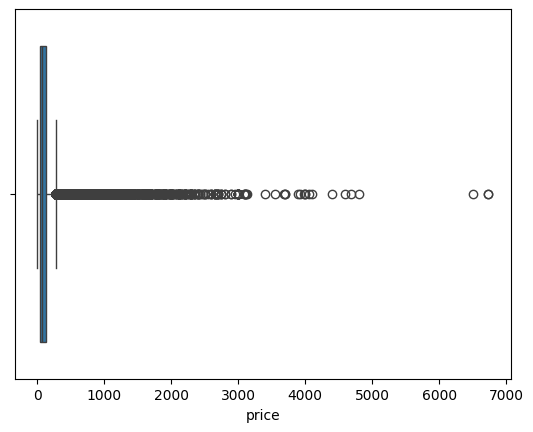

In [35]:
sns.boxplot(x=order_items["price"])
plt.show()

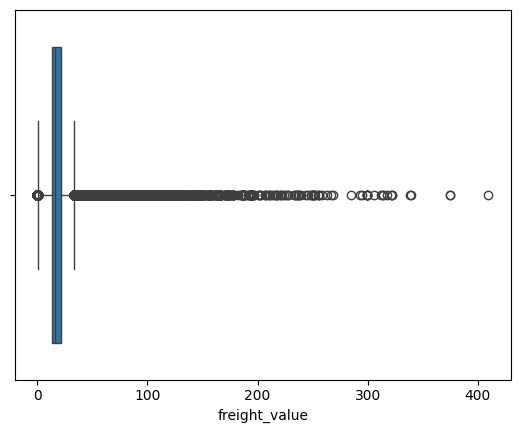

In [36]:
sns.boxplot(x=order_items["freight_value"])
plt.show()

In [37]:
# Attach product category to order items to enable category-level analysis
order_items_with_category = order_items.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)


In [38]:
# Flag price outliers per product category using an IQR-based approach
order_items_with_category['price_outlier_flag'] = iqr_outlier_flag_by_group(
    order_items_with_category,
    value_col='price',
    group_col='product_category_name',
    k=1.5,
    two_sided=True
)


In [39]:
order_items_with_category.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,price_outlier_flag
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,False
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,True
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,True
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,True


In [40]:
rate = flag_rate(order_items_with_category['price_outlier_flag'])
rate


np.float64(8.23)

In [41]:
# Flag freight value outliers per product category using an IQR-based approach

order_items_with_category['freight_value_outlier_flag'] = iqr_outlier_flag_by_group(
    order_items_with_category,
    value_col='freight_value',
    group_col='product_category_name',
    k=1.5,
    two_sided=True
)


In [42]:
# Calculate the proportion of freight value outliers

freight_outlier_rate = flag_rate(
    order_items_with_category['freight_value_outlier_flag']
)
freight_outlier_rate


np.float64(8.55)

In [43]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [44]:
# Convert shipping limit date to datetime format

order_items["shipping_limit_date"] = pd.to_datetime(
    order_items["shipping_limit_date"],
    errors='coerce'
)


In [45]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [46]:
order_items_with_category.query("price <= 0")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,price_outlier_flag,freight_value_outlier_flag


In [47]:
order_items_with_category.query("freight_value < 0")


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,price_outlier_flag,freight_value_outlier_flag


### Outlier Analysis

Outliers in price and freight values are evaluated using the Interquartile Range (IQR)
method on a per-category basis.

These extreme values are retained, as they often correspond to legitimate high-value
transactions or premium products that are important for revenue analysis.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Products Dataset

The products dataset contains descriptive attributes and category information
for items sold on the platform.

Cleaning efforts focus on ensuring category consistency and handling missing
attributes without reducing product-level granularity.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [48]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [49]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [50]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [51]:
products.isna().any()

product_id                    False
product_category_name          True
product_name_lenght            True
product_description_lenght     True
product_photos_qty             True
product_weight_g               True
product_length_cm              True
product_height_cm              True
product_width_cm               True
dtype: bool

In [52]:
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [53]:
products[products["product_category_name"].isna()].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0


In [54]:
missing_rate = products.isna().mean() * 100
missing_rate

product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

In [55]:
# Check whether missing values across product attributes occur together (missing pattern consistency)
mask_category = products['product_category_name'].isna()
mask_name = products['product_name_lenght'].isna()
mask_desc = products['product_description_lenght'].isna()
mask_photos = products['product_photos_qty'].isna()

(mask_category == mask_name).all(), \
(mask_name == mask_desc).all(), \
(mask_desc == mask_photos).all()


(np.True_, np.True_, np.True_)

In [56]:
products['missing_metadata_flag'] = mask_category

In [57]:
products['product_category_name'] = products['product_category_name'].fillna('unknown')

products['product_name_lenght'] = products['product_name_lenght'].fillna(0)
products['product_description_lenght'] = products['product_description_lenght'].fillna(0)
products['product_photos_qty'] = products['product_photos_qty'].fillna(0)

In [58]:
products = products.dropna(
    subset=[
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm'
    ]
)

In [59]:
products.isna().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
missing_metadata_flag         0
dtype: int64

### Missing Values Handling

A small proportion of missing values (less than 2% of the dataset) was identified
in product category, name length, description length, and photo quantity columns.
These missing values consistently occurred together, indicating incomplete but
structurally related product records.

To avoid distorting the dataset or introducing unnecessary bias:
- Missing numeric fields were replaced with zero.
- Missing product categories were labeled as "unknown" to preserve categorical consistency.

Additionally, two anomalous rows were removed, as they contained no meaningful
information and were statistically insignificant relative to the overall dataset size.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [60]:
products.duplicated().sum()

np.int64(0)

In [61]:
# Compute outlier rates for physical product attributes per category (upper-bound only)

physical_cols = [
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

outlier_summary = {
    col: flag_rate(
        iqr_outlier_flag_by_group(
            products,
            value_col=col,
            group_col='product_category_name',
            k=1.5,
            two_sided=False   # physical attributes → upper bound only
        )
    )
    for col in physical_cols
}

outlier_summary


{'product_weight_g': np.float64(10.45),
 'product_length_cm': np.float64(4.65),
 'product_height_cm': np.float64(4.39),
 'product_width_cm': np.float64(3.49)}

In [62]:
zero_weight = products[products['product_weight_g'] == 0]
zero_weight.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,missing_metadata_flag
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,cama_mesa_banho,51.0,529.0,1.0,0.0,30.0,25.0,30.0,False
13683,8038040ee2a71048d4bdbbdc985b69ab,cama_mesa_banho,48.0,528.0,1.0,0.0,30.0,25.0,30.0,False
14997,36ba42dd187055e1fbe943b2d11430ca,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0,False
32079,e673e90efa65a5409ff4196c038bb5af,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0,False


In [63]:
products = products.drop(
    products[products['product_weight_g'] == 0].index
)

In [64]:
products['product_category_name'].value_counts().head(10)


product_category_name
cama_mesa_banho           3025
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: count, dtype: int64

In [65]:
products['product_category_name'].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio',
       'unknown', 'moveis_sala', 'sinalizacao_e_seguranca',
       'climatizacao', 'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa

### Duplicate and Outlier Assessment

The products table was examined for duplicate records, and no duplicates were identified.

An IQR-based analysis was conducted at the product category level to evaluate outlier
rates in physical attributes. The observed proportions of outliers were approximately:
- Weight: ~10%
- Length: ~4.5%
- Height: ~4.5%
- Width: ~3.5%

To ensure data validity, records were further screened for noisy or invalid values,
such as non-positive or clearly incorrect physical measurements. Based on this check,
four invalid rows were removed, as they did not represent plausible real-world products.

Remaining outliers were intentionally retained, as variation in product size and weight
is expected in an e-commerce context. Preserving these values helps maintain the true
distribution of physical attributes for downstream analysis and modeling.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## order payments Dataset

In [66]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [67]:
order_payments.isna().any()

order_id                False
payment_sequential      False
payment_type            False
payment_installments    False
payment_value           False
dtype: bool

In [68]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [69]:
order_payments.duplicated().sum()

np.int64(0)

In [70]:
# Flag payment value outliers per payment type using an IQR-based approach
payment_flag = iqr_outlier_flag_by_group(
    order_payments,
    value_col='payment_value',
    group_col='payment_type',
    k=1.5,
    two_sided=True
)

# Calculate the proportion of payment value outliers
payment_outlier_rate = flag_rate(payment_flag)
payment_outlier_rate


np.float64(7.7)

In [71]:
order_payments["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [72]:
# Aggregate total payment value per order
payments_sum = (
    order_payments
    .groupby('order_id')['payment_value']
    .sum()
    .reset_index(name='total_paid')
)


In [73]:
# Compute total order value by summing item prices and freight costs
order_value = (
    order_items
    .groupby('order_id')[['price', 'freight_value']]
    .sum()
    .sum(axis=1)
    .reset_index(name='order_value')
)


In [74]:
# Validate consistency between total payments and computed order value
check = payments_sum.merge(order_value, on='order_id')

check['diff'] = check['total_paid'] - check['order_value']

# Inspect absolute differences to confirm data consistency
check['diff'].abs().describe()


count    98665.000000
mean         0.033162
std          1.129109
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        182.810000
Name: diff, dtype: float64

##

No missing values or duplicates were found in the payments table.

Outliers in payment_value (~7.7%) were identified using IQR and retained as valid high-value transactions.

Categorical fields showed no noise. A consistency check between summed payments and computed order values resulted in zero differences, confirming data integrity.


##

**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Customers Dataset

This dataset captures customer identifiers and geographic attributes, allowing
analysis of customer behavior and repeat purchasing patterns.


In [75]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [76]:
customers.isna().any()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool

In [77]:
customers.duplicated().sum()

np.int64(0)

In [78]:
customers['customer_city'] = (
    customers['customer_city']
    .str.strip()
    .str.lower()
)

In [79]:
customers['customer_city'].nunique()

4119

In [80]:
customers['customer_city'].unique()

array(['franca', 'sao bernardo do campo', 'sao paulo', ...,
       'monte bonito', 'sao rafael', 'eugenio de castro'],
      shape=(4119,), dtype=object)

In [81]:
customers['customer_city'].value_counts().head(20)


customer_city
sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
niteroi                    849
santo andre                797
osasco                     746
santos                     713
goiania                    692
sao jose dos campos        691
fortaleza                  654
sorocaba                   633
recife                     613
florianopolis              570
Name: count, dtype: int64

### Customer Data Validation

The customers table consists exclusively of categorical fields; therefore, outlier
detection was not applicable.

No missing values or duplicate records were identified in this dataset.

City names were standardized by applying lowercasing and trimming to reduce textual
noise and ensure consistency. The most frequent city values were reviewed, and no
anomalies or data quality issues were detected.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Sellers Dataset

The sellers dataset represents marketplace participants responsible for fulfilling
customer orders.

It supports seller performance, delivery reliability, and geographic distribution
analysis.


In [82]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [83]:
sellers.isna().any()

seller_id                 False
seller_zip_code_prefix    False
seller_city               False
seller_state              False
dtype: bool

In [84]:
sellers.duplicated().sum()

np.int64(0)

In [85]:
sellers['seller_city'] = (
    sellers['seller_city']
    .str.strip()
    .str.lower()
)

In [86]:
sellers['seller_city'].value_counts().head(20)


seller_city
sao paulo                694
curitiba                 127
rio de janeiro            96
belo horizonte            68
ribeirao preto            52
guarulhos                 50
ibitinga                  49
santo andre               45
campinas                  41
maringa                   40
sao jose do rio preto     33
sorocaba                  32
sao bernardo do campo     32
osasco                    32
porto alegre              28
brasilia                  28
londrina                  26
goiania                   23
joinville                 22
blumenau                  21
Name: count, dtype: int64

### Seller Data Validation

The sellers table was examined for missing values and duplicate records, and no
data quality issues were identified.

City names were standardized through lowercasing and trimming to reduce textual
noise and improve consistency. Frequently occurring city values were reviewed and
found to be coherent and reliable for seller-level analysis.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Reviews Dataset

Customer reviews provide post-delivery feedback and serve as a key indicator of
customer satisfaction.


In [87]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [88]:
order_reviews.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [89]:
# Convert review creation and answer timestamps to datetime format

order_reviews['review_creation_date'] = pd.to_datetime(
    order_reviews['review_creation_date']
)

order_reviews['review_answer_timestamp'] = pd.to_datetime(
    order_reviews['review_answer_timestamp']
)


In [90]:
order_reviews.dtypes

review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

In [91]:
order_reviews.isna().any()

review_id                  False
order_id                   False
review_score               False
review_comment_title        True
review_comment_message      True
review_creation_date       False
review_answer_timestamp    False
dtype: bool

In [92]:
# Handle missing review text and create a flag indicating presence of a written review

order_reviews['review_comment_message'] = (
    order_reviews['review_comment_message']
    .fillna('no_comment')
)

order_reviews['has_text_review'] = (
    order_reviews['review_comment_message']
    .ne('no_comment')
).astype(int)



In [93]:
# Handle missing review titles and create a flag indicating presence of a review title

order_reviews['review_comment_title'] = (
    order_reviews['review_comment_title']
    .fillna('no_title')
)

order_reviews['has_title_review'] = (
    order_reviews['review_comment_title']
    .ne('no_title')
).astype(int)


In [94]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,has_text_review,has_title_review
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no_title,no_comment,2018-01-18,2018-01-18 21:46:59,0,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no_title,no_comment,2018-03-10,2018-03-11 03:05:13,0,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no_title,no_comment,2018-02-17,2018-02-18 14:36:24,0,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,no_title,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,1,0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,no_title,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,1,0


In [95]:
order_reviews.duplicated().sum()

np.int64(0)

In [96]:
order_reviews['review_score'].unique()

array([4, 5, 1, 3, 2])

In [97]:
invalid_review_mask = (
    order_reviews['review_answer_timestamp'] <
    order_reviews['review_creation_date']
)


In [98]:
invalid_review_mask.sum()

np.int64(0)

### Review Data Validation

Data types were validated, and review-related timestamp columns were converted to
datetime format to ensure temporal consistency.

Missing values were limited to review titles and review messages only. These fields
were populated with explicit placeholders ("no_title" and "no_comment"), and simple
binary flags were added to indicate the presence or absence of review text.

Duplicate records, review score validity, and the chronological order of review
events were examined. No data quality issues were identified in these checks.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Category Dataset

In [99]:
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [100]:
category.isna().any()

product_category_name            False
product_category_name_english    False
dtype: bool

In [101]:
category.duplicated().sum()

np.int64(0)

In [102]:
len(category["product_category_name_english"].unique())

71

In [103]:
len(category["product_category_name"].unique())

71

In [104]:
category["product_category_name_english"].head(10)

0            health_beauty
1    computers_accessories
2                     auto
3           bed_bath_table
4          furniture_decor
5           sports_leisure
6                perfumery
7               housewares
8                telephony
9            watches_gifts
Name: product_category_name_english, dtype: object

In [105]:
category[
    category['product_category_name'].notna() &
    category['product_category_name_english'].isna()
]


,product_category_name,product_category_name_english


### Category Mapping Validation

The category mapping table was reviewed and found to contain no missing values or
duplicate records. A complete and consistent one-to-one mapping was confirmed
between Portuguese and English product category names.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

# Export data

In [106]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_stage                              object
timeline_issue_flag                       int64
delivery_delay_days                     float64
approved_date                            object
dtype: object

In [107]:
# Export cleaned datasets for downstream SQL analysis and EDA

orders.to_csv("../Data/clean_data/orders_clean.csv", index=False)
order_items.to_csv("../Data/clean_data/order_items_clean.csv", index=False)
products.to_csv("../Data/clean_data/products_clean.csv", index=False)
order_payments.to_csv("../Data/clean_data/order_payments_clean.csv", index=False)
order_reviews.to_csv("../Data/clean_data/order_reviews_clean.csv", index=False)
customers.to_csv("../Data/clean_data/customers_clean.csv", index=False)
sellers.to_csv("../Data/clean_data/sellers_clean.csv", index=False)
category.to_csv("../Data/clean_data/category_clean.csv", index=False)


## Order Completion & Delivery Delay Features

- **order_completion_status**: A simplified analytical indicator derived from `order_stage`.
  - `completed` if the order is completed.
  - `not_completed` otherwise.
- **delivery_delay_days**: Late-delivery duration in days for completed orders only.
  - `0` means delivered on time or early.
  - `NaN` for non-completed orders (no final delivery date).


## Data Quality Summary

A consolidated summary is generated to evaluate dataset completeness, duplication,
and overall readiness for analysis before proceeding to exploratory analysis.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [108]:
# Final snapshot: quick sanity checks for missing values and duplicate rows
# This snapshot reflects the final state of the cleaned datasets

tables = {
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "order_payments": order_payments,
    "order_reviews": order_reviews,
    "customers": customers,
    "sellers": sellers,
    "category": category
}

for name, df in tables.items():
    print(f"\n===== {name.upper()} =====")
    
    # Check missing values per column
    print("Missing values:")
    print(df.isna().sum())
    
    # Check duplicate rows
    print("\nDuplicate rows:" , end = " ===> ")
    print(df.duplicated().sum())



===== ORDERS =====
Missing values:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1781
order_delivered_customer_date    2957
order_estimated_delivery_date       0
order_stage                         0
timeline_issue_flag                 0
delivery_delay_days              2957
approved_date                     146
dtype: int64

Duplicate rows: ===> 0

===== ORDER_ITEMS =====
Missing values:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Duplicate rows: ===> 0

===== PRODUCTS =====
Missing values:
product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g    

## SQL Export Strategy

Cleaned datasets are exported as separate relational tables.

Table joins are deferred to the SQL or BI layer to maintain flexibility, optimize
performance, and support multiple analytical use cases.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

In [109]:
import os
import pandas as pd
from sqlalchemy import create_engine

SERVER = "localhost"
DATABASE = "Olist"

conn_str = (
    "mssql+pyodbc://"
    f"{SERVER}/{DATABASE}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

engine = create_engine(conn_str, fast_executemany=True)

CLEAN_DIR = os.path.join("..", "Data", "clean_data")

files = {
    "orders_clean": "orders_clean.csv",
    "order_items_clean": "order_items_clean.csv",
    "products_clean": "products_clean.csv",
    "order_payments_clean": "order_payments_clean.csv",
    "order_reviews_clean": "order_reviews_clean.csv",
    "customers_clean": "customers_clean.csv",
    "sellers_clean": "sellers_clean.csv",
    "category_clean": "category_clean.csv",
}

SCHEMA = "dbo"

print("CWD:", os.getcwd())
print("CLEAN_DIR:", os.path.abspath(CLEAN_DIR))
print("Files there:", os.listdir(CLEAN_DIR)[:10])

for table_name, filename in files.items():
    path = os.path.join(CLEAN_DIR, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")

    df = pd.read_csv(path)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    n_cols = df.shape[1]
    chunksize = max(1, 2000 // n_cols)

    df.to_sql(
        name=table_name,
        con=engine,
        schema=SCHEMA,
        if_exists="replace",
        index=False,
        chunksize=chunksize,
        method="multi"  
    )

    print(f"✅ Uploaded: {table_name} ({len(df):,} rows) | chunksize={chunksize}")


CWD: F:\work_space\Olist\notebooks
CLEAN_DIR: F:\work_space\Olist\Data\clean_data
Files there: ['category_clean.csv', 'customers_clean.csv', 'orders_clean.csv', 'order_items_clean.csv', 'order_payments_clean.csv', 'order_reviews_clean.csv', 'products_clean.csv', 'sellers_clean.csv']
✅ Uploaded: orders_clean (99,441 rows) | chunksize=166
✅ Uploaded: order_items_clean (112,650 rows) | chunksize=285
✅ Uploaded: products_clean (32,945 rows) | chunksize=200
✅ Uploaded: order_payments_clean (103,886 rows) | chunksize=400
✅ Uploaded: order_reviews_clean (99,224 rows) | chunksize=222
✅ Uploaded: customers_clean (99,441 rows) | chunksize=400
✅ Uploaded: sellers_clean (3,095 rows) | chunksize=500
✅ Uploaded: category_clean (71 rows) | chunksize=1000


In [110]:
files = {
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "order_payments": order_payments,
    "order_reviews": order_reviews,
    "customers": customers,
    "sellers": sellers,
    "category": category
}

for name, df in files.items():
    print(f"{name:20} {len(df):,}")


orders               99,441
order_items          112,650
products             32,945
order_payments       103,886
order_reviews        99,224
customers            99,441
sellers              3,095
category             71


## Data Cleaning Decisions Log

Key decisions made during this phase include:

- Outliers were retained to preserve meaningful high-value business cases.
- Timeline inconsistencies were flagged instead of corrected.
- Duplicate reference records were kept where they represent valid mappings.
- No records were removed unless analytically unusable.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.

## Conclusion

At the end of the data cleaning phase, all datasets are structurally consistent,
analytically reliable, and ready for exploratory analysis, SQL querying, and
dashboard development.


**Business relevance:**
This step ensures downstream business analysis is not biased or misleading, allowing reliable insights related to revenue trends, delivery performance, and customer satisfaction.